# Final model evaluation
- Model overall SMAPE score
- Model per-bucket robustness evaluation

In [1]:
import json
import sagemaker
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Interface of this file
# Input: S3 path of json lines
# Output: original time series list and predicted time series list

input_path = "s3://sagemaker-deepar20190120/sagemaker/wiki-test-deepar/data/test/test.json"
freq = 'H'
prediction_length = 48
context_length = 118
ep = "DEMO-deepar-2019-02-17-20-18-00-289"
sagemaker_session = sagemaker.Session()

In [3]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + 1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq,
                                                periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df


# helper func
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj


# helper func
def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [4]:
predictor = DeepARPredictor(
    endpoint=ep,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)


predictor.set_prediction_parameters(freq, prediction_length)

In [5]:
# Input: json lines, string or file path or S3 url
# Output: list of original time series, list of predicted DATA FRAME
def get_predictions(input_path):
    df_ts = pd.read_json(input_path, lines=True)
    num_pt = len(df_ts.iloc[1, 1])
    num_ts = len(df_ts)
    ts_orig = []
    ts_to_pred = []
    for k in range(num_ts):
        t0 = df_ts.iloc[k, 0]
        data = df_ts.iloc[k, 1]
        index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
        ts = pd.Series(data=data, index=index)
        ts_0val = ts.replace({np.nan: 0}, inplace = False)
        # Only replace missing values to 0 when doing plotting, NOT in prediction!
        ts_orig.append(ts_0val)
        # Predictor only recognizes null literal as missing values, not np.nan.
        ts.replace({np.nan: None}, inplace = True)
        ts_to_pred.append(ts[:-prediction_length])
        
    ts_predicted = []
    for series in ts_to_pred:
        ts_predicted.append(predictor.predict([series]))
        time.sleep(0.01)
    return ts_orig, ts_predicted


In [6]:
# big call here!!!
time_series_wiki, list_of_wiki_pred = get_predictions(input_path)


## A quick overview of prediction

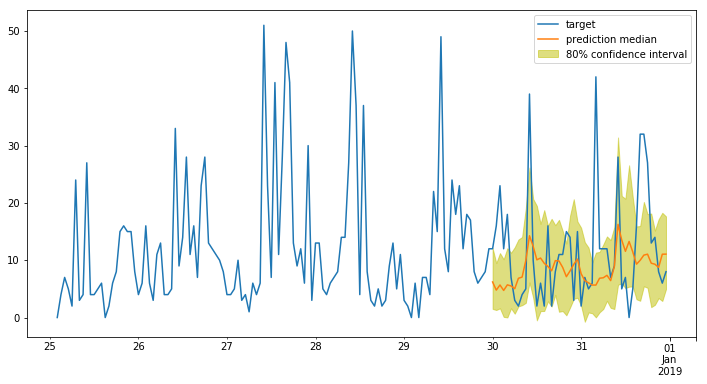

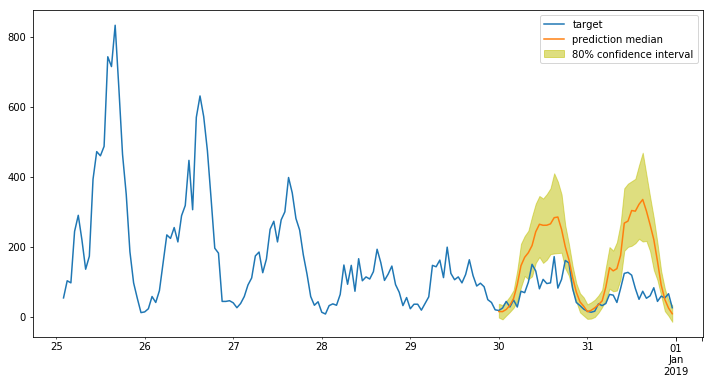

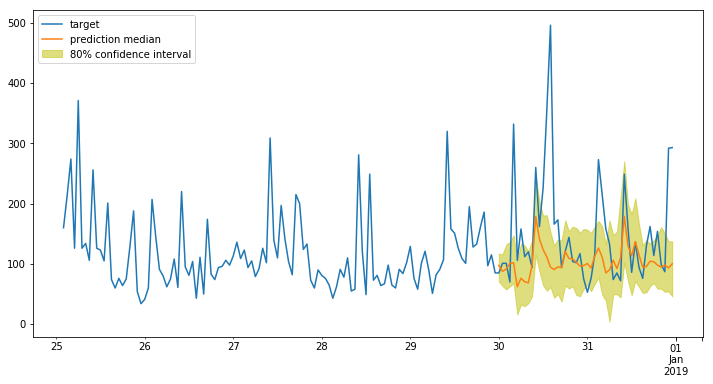

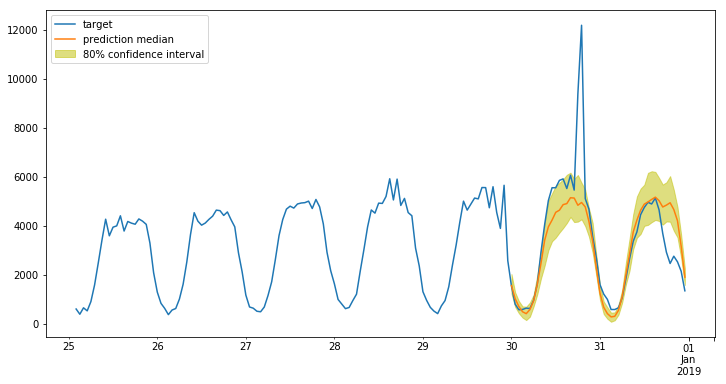

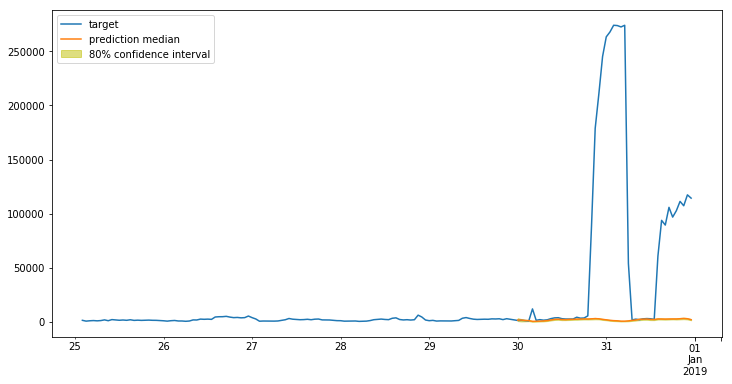

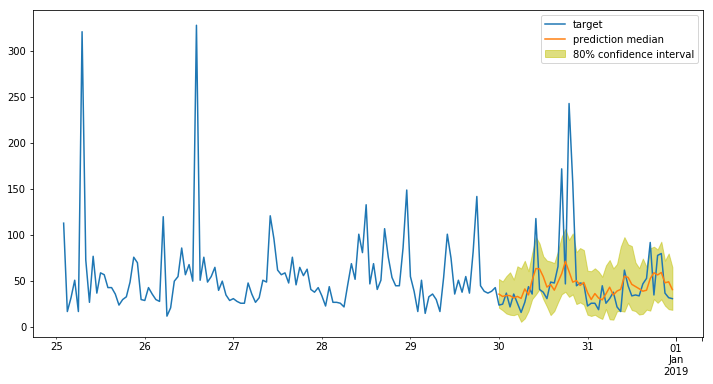

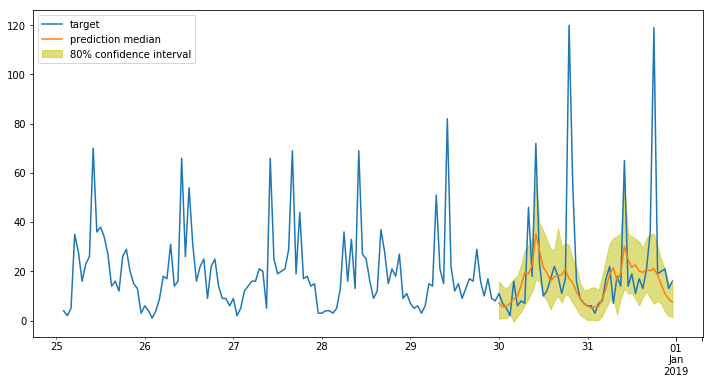

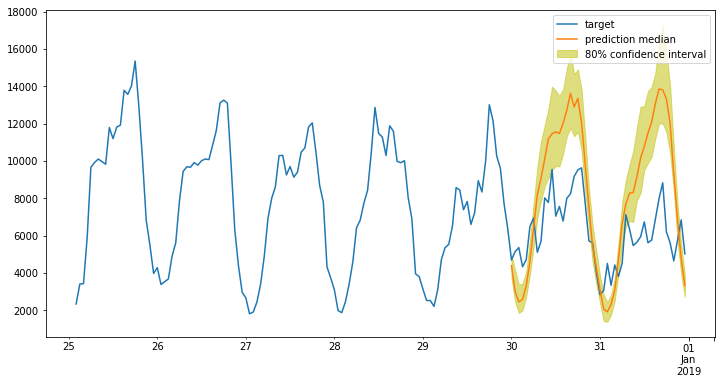

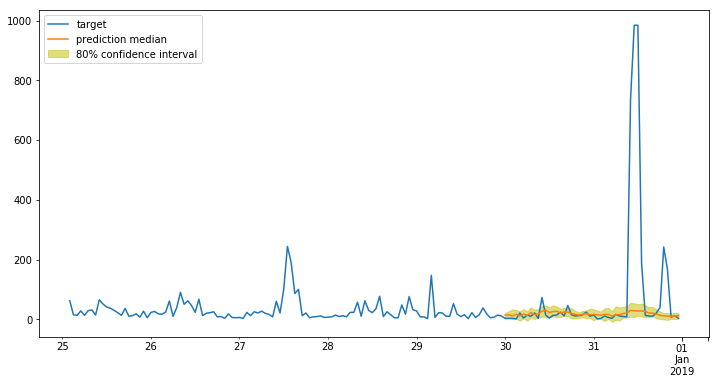

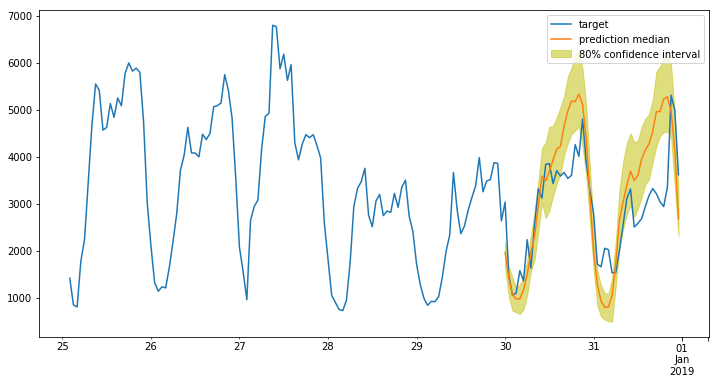

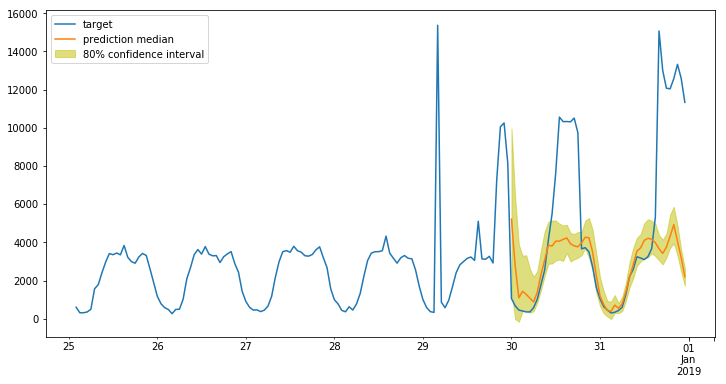

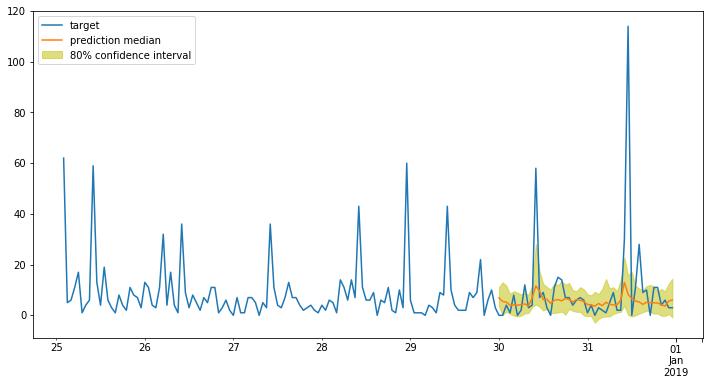

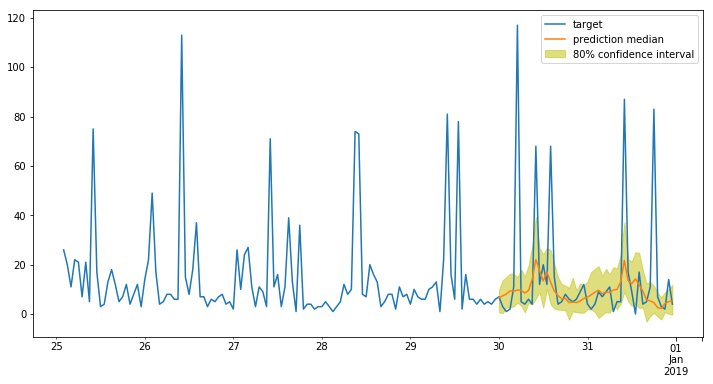

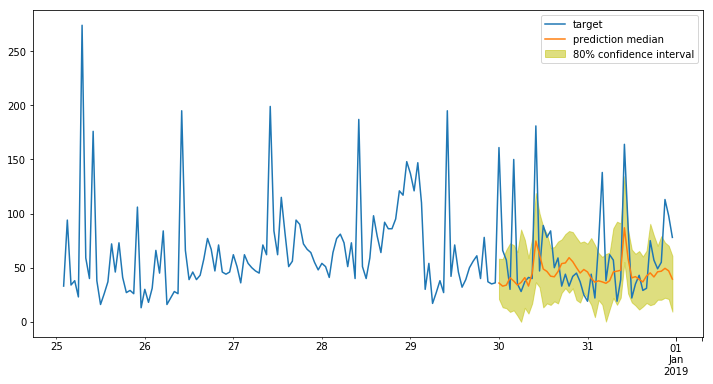

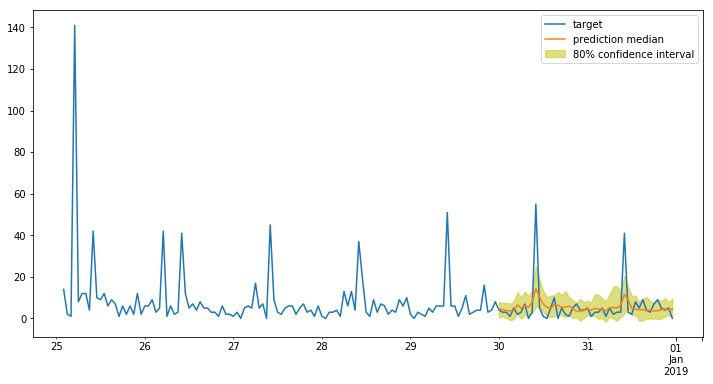

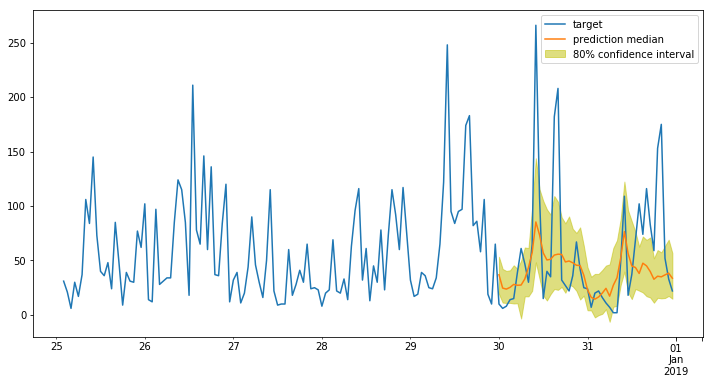

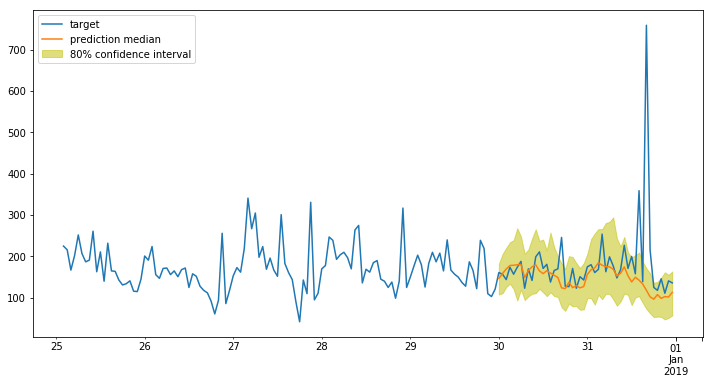

In [7]:
# sample several predicted time series use range(0, len(list_of_wiki_pred), 50)
for k in range(0, len(list_of_wiki_pred), 50):
    plt.figure(figsize=(12,6))
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.legend(loc = 'best')
    plt.show()

### Metrics to evaluate prediction
- Symmetric mean absolute percentage error (differentiable, used in the following analysis)
- Symmetric mean absolute percentage error (starndard definition)
- Mean absolute percentage error

In [8]:
# Approximated differentiable SMAPE
def differentiable_smape(true, predicted):
    epsilon = 0.1
    true_o = true
    pred_o = predicted
    summ = np.maximum(np.abs(true_o) + np.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = np.abs(pred_o - true_o) / summ
    return smape

# SMAPE stardard definition
def smape(true, predicted):
    true_o = true
    pred_o = predicted
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# MAPE standard definition
def mape(true, predicted):
    true_o = true
    pred_o = predicted
    denom = np.abs(true_o)
    mape = np.where(denom==0, 0, np.abs(pred_o - true_o) / denom)
    return mape

In [9]:
# input pd.series in which index = time stamps, value = time series values
# actual_series and pred_series should have exactly matched timestamps

def plot_metrics(actual_series, pred_series):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    metric_smape = differentiable_smape(actual_series.values, pred_series.values)
    metric_mape = mape(actual_series.values, pred_series.values)
    metric_smape_orig = smape(actual_series.values, pred_series.values)
    plt.figure(figsize=(12,6))
    plt.plot(pred_series.index, metric_smape_orig, label = 'smape standard = {}'.format(metric_smape_orig.mean()))  
    plt.plot(pred_series.index, metric_smape, label = 'smape differentialble = {}'.format(metric_smape.mean()))
    plt.plot(pred_series.index, metric_mape, label = 'mape standard = {}'.format(metric_mape.mean()))
    plt.xlabel('Time stamp of prediction')
    plt.ylabel('Prediction metric')
    plt.legend(loc = 'best')
    plt.show()

## Plot the metrics for wiki data prediction

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in true_divide


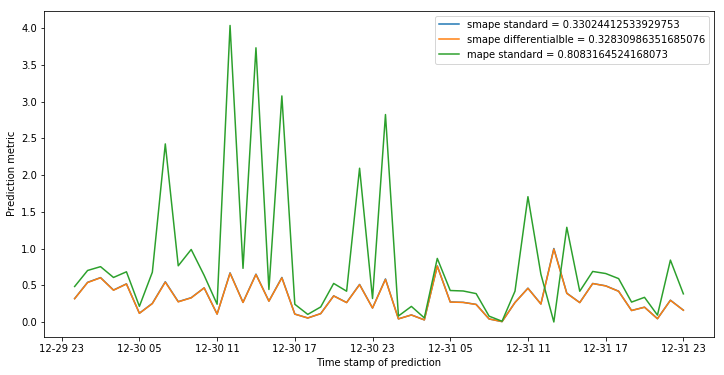

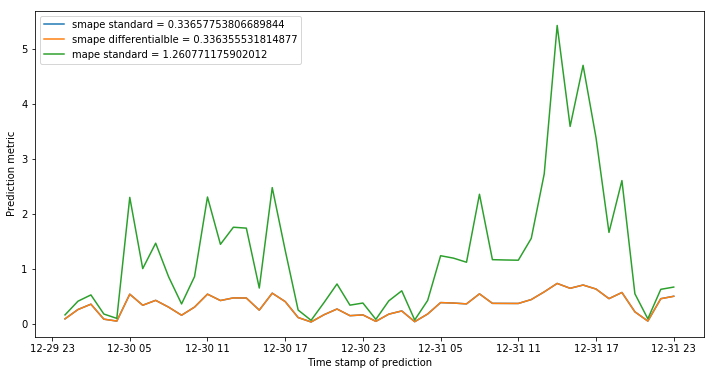

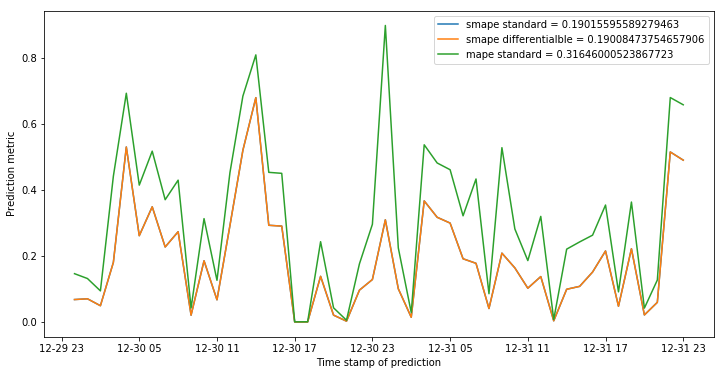

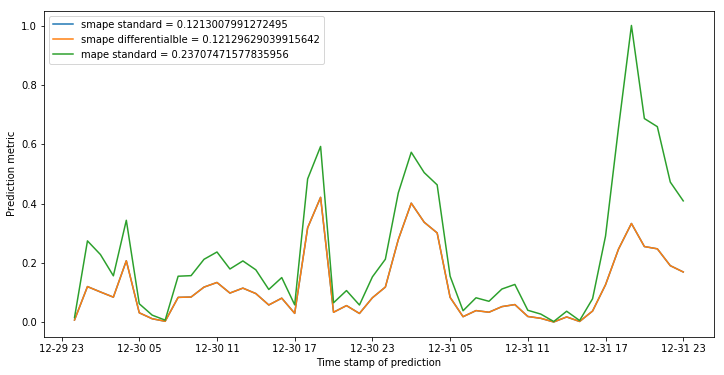

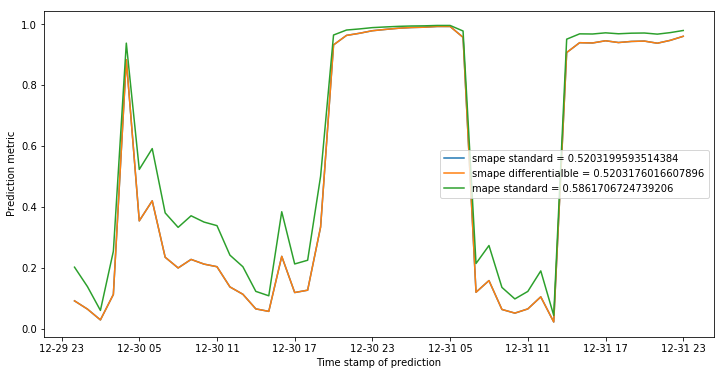

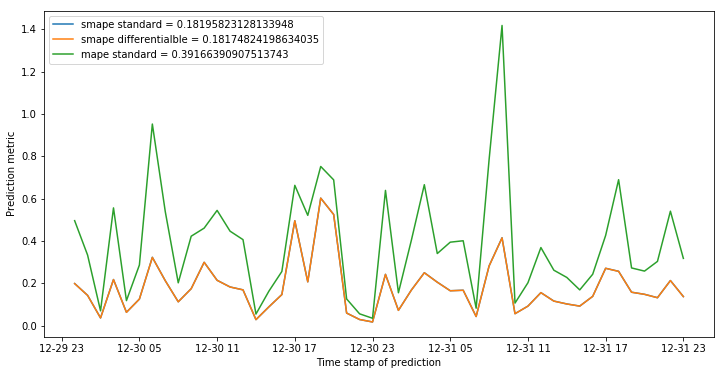

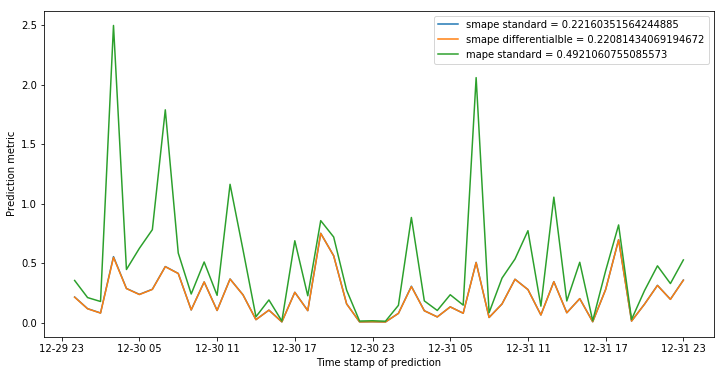

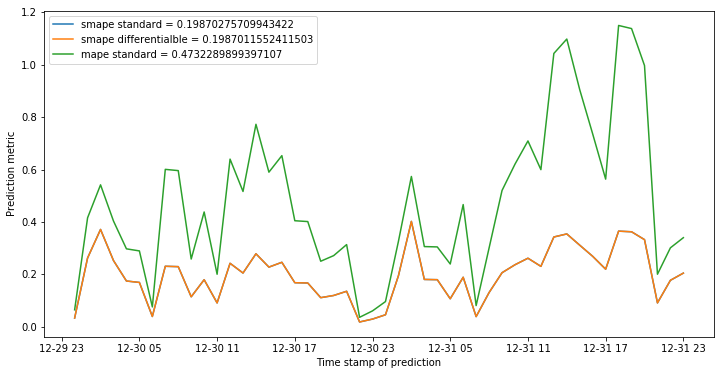

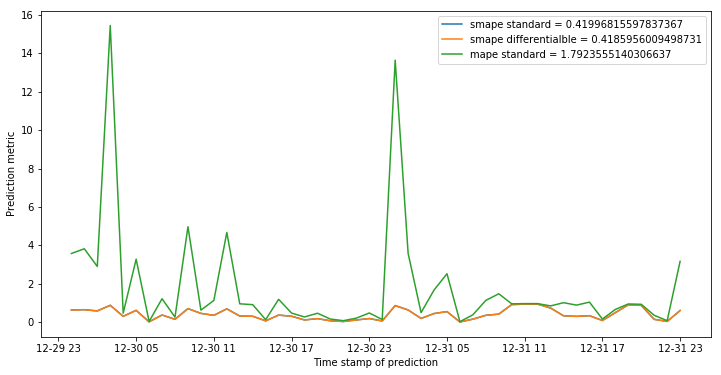

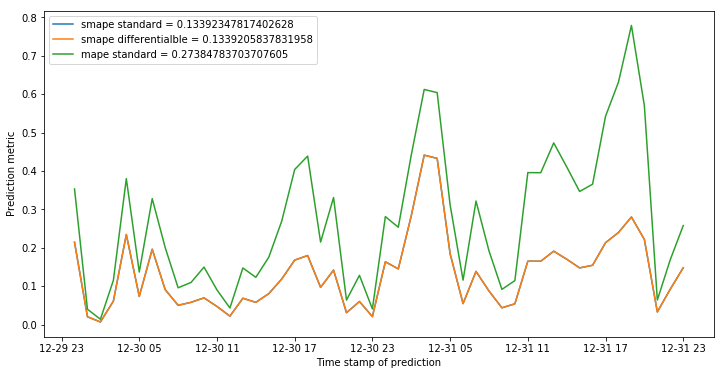

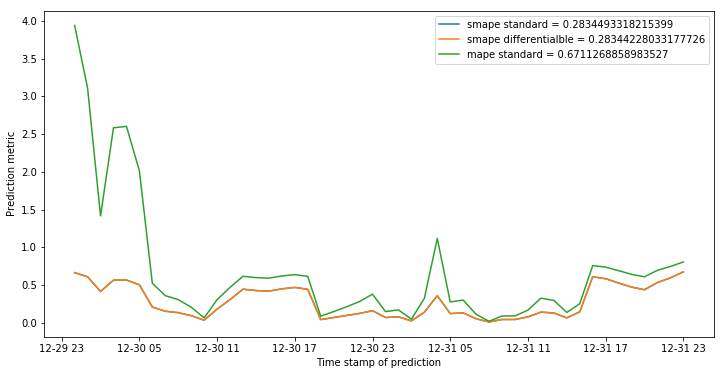

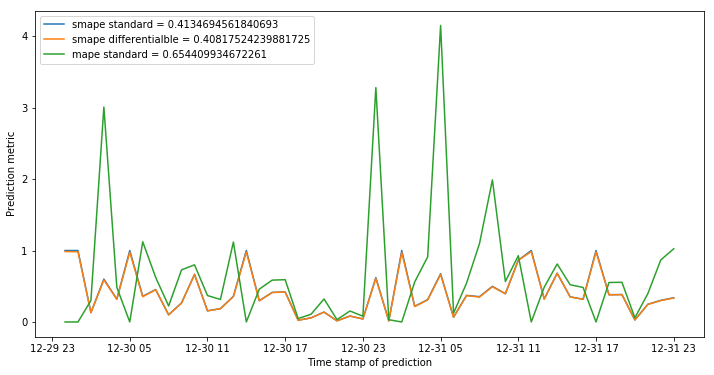

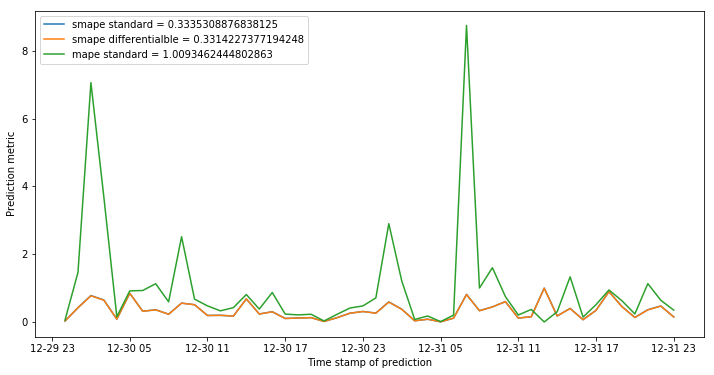

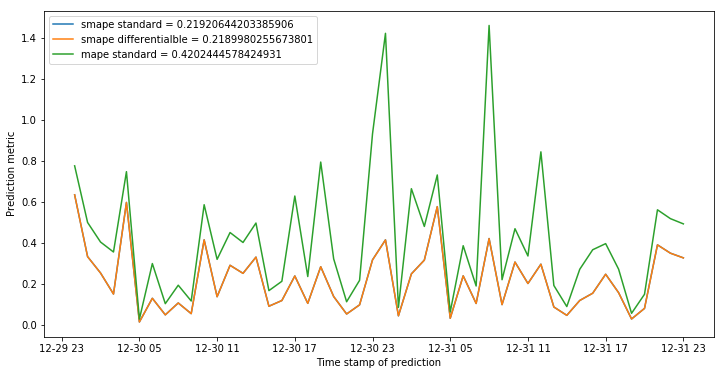

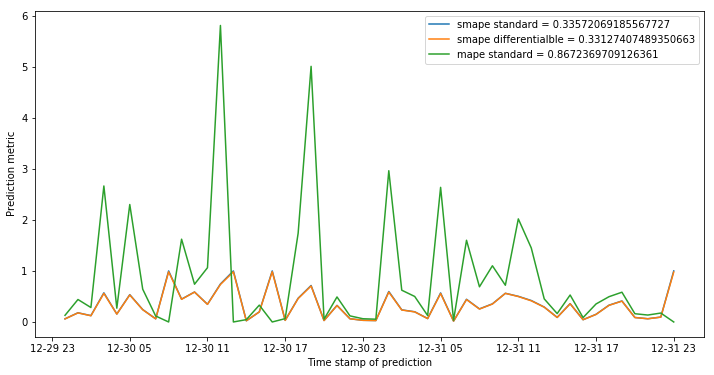

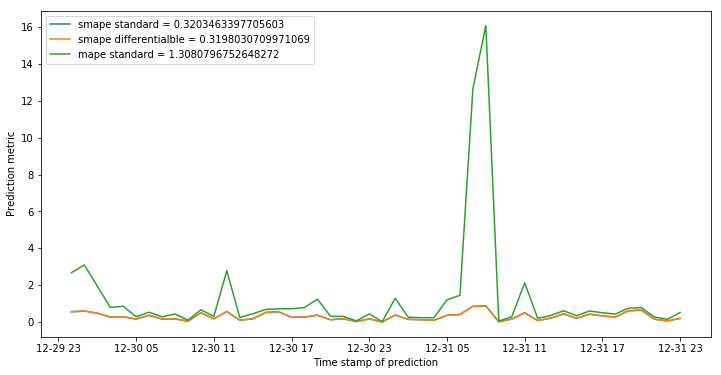

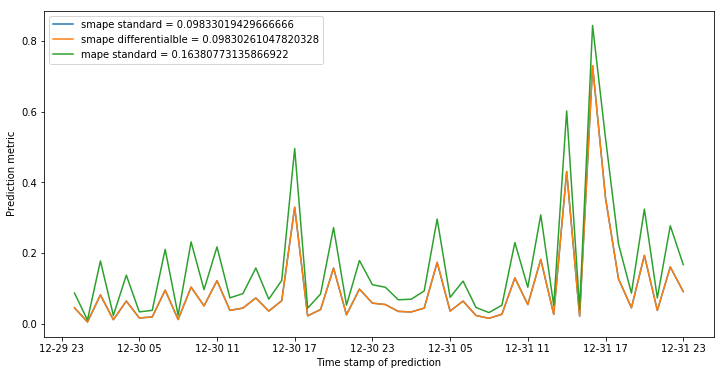

In [10]:
for k in range(0, len(list_of_wiki_pred), 50):
    plot_metrics(time_series_wiki[k][-prediction_length:], list_of_wiki_pred[k][0]['0.5'])

In [11]:
# time series characterization with FFT
import heapq
def characterize_ts(ts, window):
    y = ts.values  # signal
    Fs = 1  # sampling rate, in our case let's use 1 Hour^-1
    n = len(y)  # length of the signal
    k = np.arange(n)
    T = n / Fs
    frq = k / T  # two sides frequency range
    # We only keep the positive frequency up to the Nyquist = 1/(2*dT), dT = sampling interval.
    cycle = frq[range(1, int(n / 2))] * window  # one side frequency range

    Y = np.fft.fft(y) / n  # fft computing and normalization
    Y = Y[range(1, int(n / 2))]  # again, spectrum corrresponding to the positive half
    yabs = np.abs(Y)

    # Locate the largest 15 peaks, use them to characterise the time series.
    indx = heapq.nlargest(15, range(len(yabs)), yabs.__getitem__)
    amp = heapq.nlargest(15, yabs)

    mean = yabs.mean()
    std = yabs.std()
    cyc_hday = 2.0
    cyc_day = cyc_hday / 2.0
    cyc_week = cyc_day / 7.0
    cyc_month = cyc_day / 30.0

    comp = lambda a, b: np.abs(a / b - 1) < 0.05
    ts_type = ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
    report_list = [0] * 8
    for counter, value in enumerate(indx):
        # Here we define a peak in frequency domain.
        if amp[counter] > (mean + 3 * std):
            amp_norm = (amp[counter] - mean) / std
            if cycle[value] < 0.01:
                # Trend (increasing, decreasing, gaussian pulse).
                report_list[0] = max(amp_norm, report_list[0])
            elif comp(cycle[value], cyc_hday):
                report_list[1] = max(amp_norm, report_list[1])
            elif comp(cycle[value], cyc_day):
                report_list[2] = max(amp_norm, report_list[2])
            elif comp(cycle[value], cyc_week):
                report_list[3] = max(amp_norm, report_list[3])
            elif comp(cycle[value], cyc_month):
                report_list[4] = max(amp_norm, report_list[4])

    if sum(report_list[:5]) > 0:
        index = report_list[:5].index(max(report_list[:5]))
        report_list[5] = ts_type[index]
    else:
        report_list[5] = ts_type[-1]

    # Add a subcategory: a special day seasonality that has a periodic impulse shape.
    if report_list[5] == 'hDay' or report_list[5] == 'Day':
        harmonic = set(range(12))
        all_peak = set()
        for counter, value in enumerate(indx):
            if amp[counter] > (mean + 3 * std):
                all_peak.add(int(round(cycle[value])))
        if len(harmonic.intersection(all_peak)) > 10:
            report_list[5] = ts_type[-2]

    report_list[-2] = y.mean()
    report_list[-1] = y.std()
    return report_list

## Characterize time series, so we can see how the model performs across different types of workloads

In [12]:
character_list = []
day = 24
for item in time_series_wiki:
    character_list.append(characterize_ts(item,day))

### Overall SMAPE score

In [13]:
error_list = []
for i in range(len(list_of_wiki_pred)):
    metric_smape = differentiable_smape(time_series_wiki[i][-prediction_length:].values, 
                                        list_of_wiki_pred[i][0]['0.5'].values)
    error_list.append(metric_smape.mean())
print('The overall SMAPE score is {}'.format(sum(error_list)/len(error_list)))    

The overall SMAPE score is 0.24350004808438896


### SMAPE score for different types of time series
- The major types of time series in the wiki dataset are: Day seasonality, Trend seasonality, and DayImpulse. 

- The forecaster works best for Day seasonality with SMAPE score ~ 16%. Trend (SMAPE ~ 29%) and DayImpulse (SMAPE ~ 34%) have higher errors. (in comparison with the Kaggle competition for wiki day page view best SMAPE = 35.48065%), 

- We can see the model performance varies to some extent according to the scale or type. In general, the forecaster favors heavier traffic time series (higher mean amplitude).

trend  smape  0.2915704017361541  number of series  296
hDay  smape  0.20222096617444468  number of series  4
Day  smape  0.16491148670041592  number of series  356
Week  smape  0.22493329629731254  number of series  1
Month  smape  0.19885864534385053  number of series  5
spike  smape  0.32178172603633914  number of series  2
DayImpulse  smape  0.3413953621333232  number of series  143


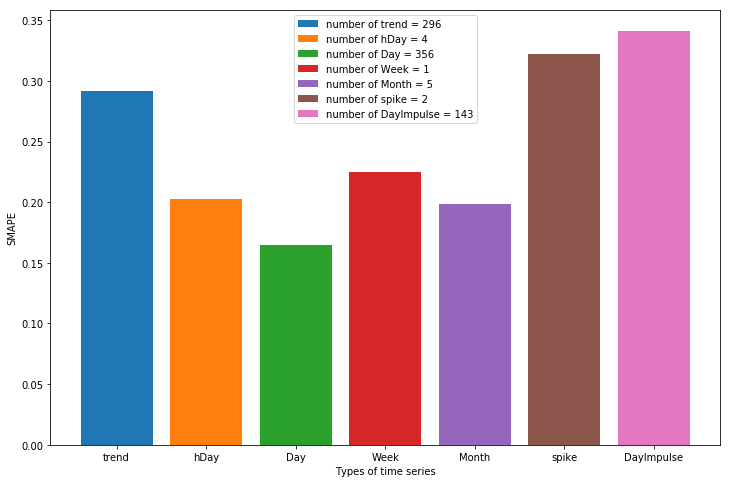

In [14]:
ans = {}
# we have ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
ans['trend'] = []
ans['hDay'] = []
ans['Day'] = []
ans['Week'] = []
ans['Month'] = []
ans['spike'] = []
ans['DayImpulse'] = []

for i in range(len(error_list)):
    ans[character_list[i][5]].append(error_list[i])

plt.figure(figsize=(12,8))  
for key, value in ans.items():
    if value:
        print(key, ' smape ', np.mean(value), ' number of series ', len(value))
        plt.bar(key, np.mean(value), label = 'number of {} = {}'.format(key, len(value)))
plt.xlabel('Types of time series')
plt.ylabel('SMAPE')
plt.legend()
plt.show()

# Detailed look into three major buckets
- Day seasonality
- Trend
- Day Impulse

### Day seasonality
- Best prediction performance.
- Clear correlation between SMAPE and mean amplitude.

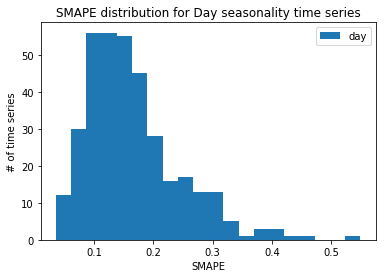

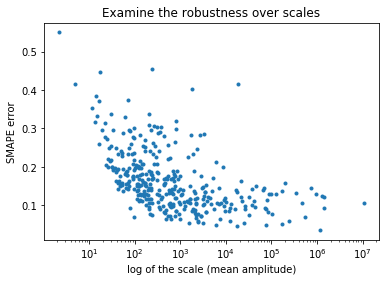

In [15]:
plt.figure()
plt.hist(ans['Day'], bins = 20, label = 'day')
plt.xlabel('SMAPE')
plt.ylabel('# of time series')
plt.title('SMAPE distribution for Day seasonality time series')
plt.legend()
plt.show()

day_mean = []
day_error = []
bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'Day'):
        day_mean.append(character_list[index][6])
        day_error.append(error_list[index])
        if error < 0.15:
            good_index.append(index)
        elif error > 0.4:
            bad_index.append(index)    

plt.figure()
plt.plot((day_mean), day_error, '.')
plt.xscale('log')
plt.xlabel('log of the scale (mean amplitude)')
plt.ylabel('SMAPE error')
plt.title('Examine the robustness over scales')
plt.show()

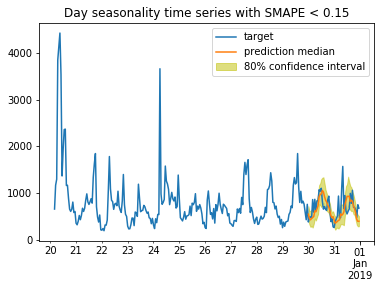

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[8.973994611561459, 0, 14.304273421800099, 0, 4.922032648925727, 'Day', 669.2184931506849, 1101.4334501834949]


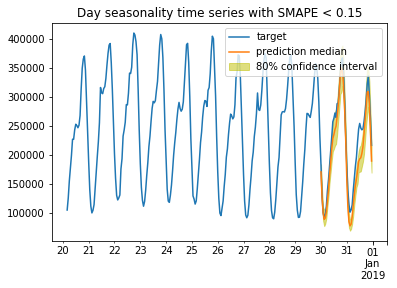

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[9.366193632172015, 19.49257953361858, 56.442911965260635, 4.485444168711687, 0, 'Day', 243617.53253424657, 96089.60703928991]


In [16]:
for k in good_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE < 0.15')
    plt.legend(loc = 'best')
    plt.show()    
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

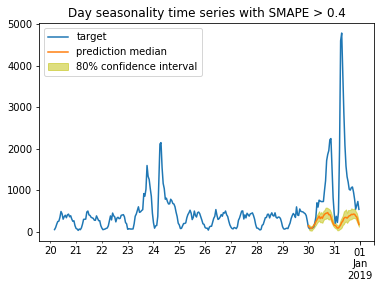

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[19.41042533470602, 15.140689277679058, 37.73321661125712, 4.210930146142056, 0, 'Day', 244.64429223744293, 222.84251652370511]


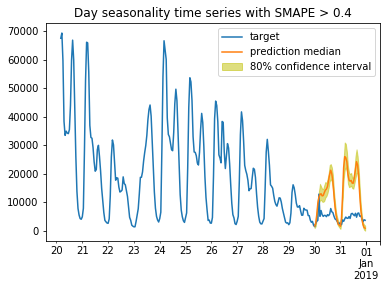

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[21.070115003379122, 26.071043956142166, 27.33296745476576, 17.206538247139385, 7.208931451837273, 'Day', 18452.2747716895, 18251.136270255523]


In [17]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE > 0.4')
    plt.legend(loc = 'best')
    plt.show()    
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

### Examine Trend type time series, the error distribution, and will the scale affect the error?

- By plotting the scale (mean amplitude, consistent with the deepAR paper definition) vs the corresponding SMAPE, we see a correlation here.

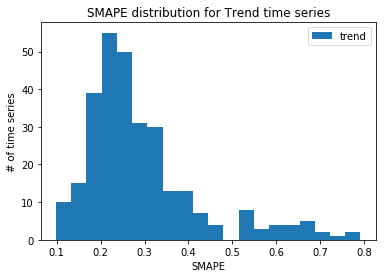

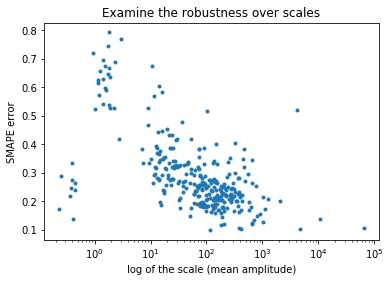

In [18]:
plt.figure()
plt.hist(ans['trend'], bins = 20, label = 'trend')
plt.xlabel('SMAPE')
plt.ylabel('# of time series')
plt.title('SMAPE distribution for Trend time series')
plt.legend()
plt.show()

trend_mean = []
trend_error = []
bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'trend'):
        trend_mean.append(character_list[index][6])
        trend_error.append(error_list[index])
        if (error < 0.15 and character_list[index][6] > 1000):
            good_index.append(index)
        elif (error > 0.5 and character_list[index][6] > 1000):
            bad_index.append(index) 

plt.figure()
plt.plot((trend_mean), trend_error, '.')
plt.xscale('log')
plt.xlabel('log of the scale (mean amplitude)')
plt.ylabel('SMAPE error')
plt.title('Examine the robustness over scales')
plt.show()

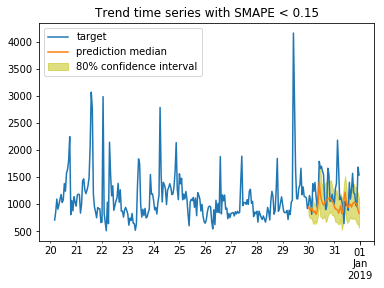

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[15.604668728717064, 0, 12.601819696538229, 7.439261695477216, 0, 'trend', 1019.6470319634703, 530.6589991310528]


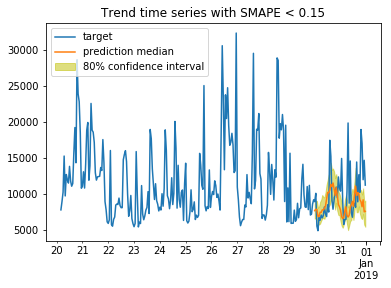

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[18.082526905610816, 0, 17.048157767856107, 10.967022067176964, 10.801628437607508, 'trend', 10742.020776255707, 6388.422780248897]


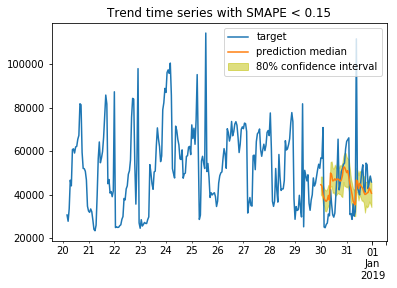

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[34.48862711912479, 0, 17.769000430518638, 6.3786406581577575, 6.4248123471731144, 'trend', 64910.92374429224, 32678.939337934524]


In [19]:
for k in good_index[1:4]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Trend time series with SMAPE < 0.15')
    plt.legend(loc = 'best')
    plt.show() 
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

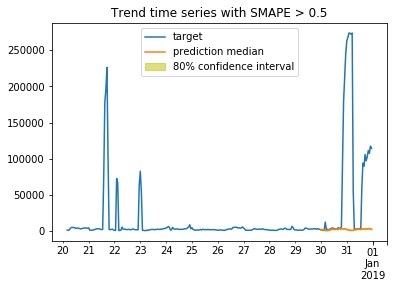

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[10.134296086414391, 0, 0, 0, 0, 'trend', 4120.293378995434, 12058.395374869264]


In [20]:
for k in bad_index:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Trend time series with SMAPE > 0.5')
    plt.legend(loc = 'best')
    plt.show()
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

### Examine DayImpulse type time series, why it has such high error?

Find the ones with high SMAPE, and see how the actual and prediction compare to each other.

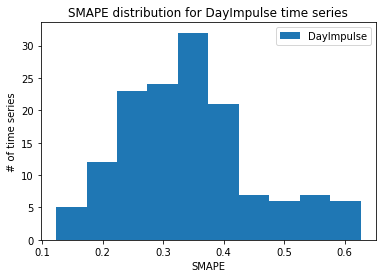

In [21]:
plt.figure()
plt.hist(ans['DayImpulse'], label = 'DayImpulse')
plt.xlabel('SMAPE')
plt.ylabel('# of time series')
plt.title('SMAPE distribution for DayImpulse time series')
plt.legend()
plt.show()

bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'DayImpulse' and error > 0.6):
        bad_index.append(index)
    elif (character_list[index][5] == 'DayImpulse' and error < 0.2):
        good_index.append(index)

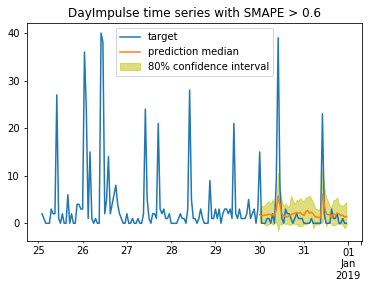

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[9.69394812295933, 12.506328812891947, 11.984547813647513, 0, 0, 'DayImpulse', 5.702283105022831, 15.216615356750177]


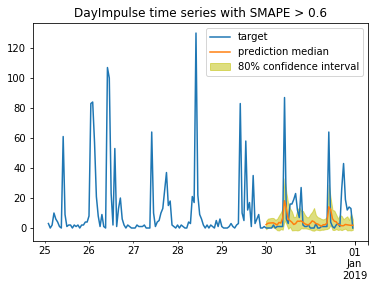

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[8.198917674787866, 15.4609070415219, 14.124947742658422, 0, 4.772296031244396, 'DayImpulse', 6.951027397260274, 20.8824935713444]


In [22]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('DayImpulse time series with SMAPE > 0.6')
    plt.legend(loc = 'best')
    plt.show()    
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

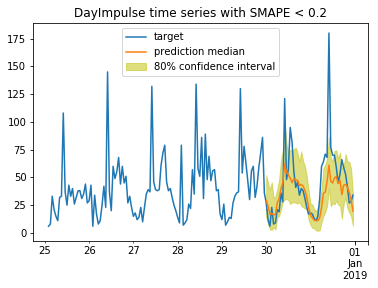

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[14.38890491514568, 14.707319453607008, 40.21717100640066, 0, 0, 'DayImpulse', 46.592351598173515, 53.83259745551839]


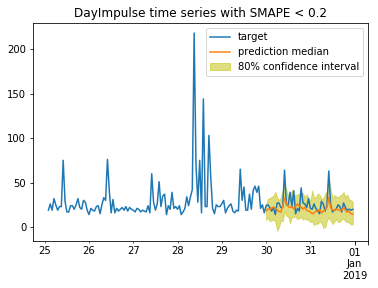

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[7.098609275007841, 9.343190639375914, 11.104972458595583, 0, 0, 'DayImpulse', 25.308333333333334, 32.176245158087724]


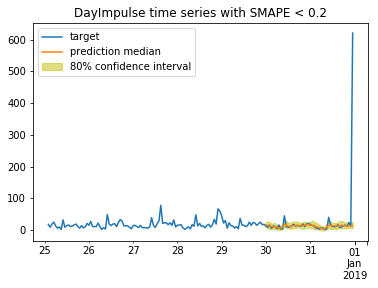

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[15.040644912887895, 16.236833835138043, 25.19340080119428, 12.37118813428284, 0, 'DayImpulse', 21.888013698630136, 19.71115954647212]


In [23]:
for k in good_index[:3]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('DayImpulse time series with SMAPE < 0.2')
    plt.legend(loc = 'best')
    plt.show()   
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])